# 13. CNN with CIFAR10

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 13.1 Prepare Data

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_data = dsets.CIFAR10(root='./data', 
                           train=True,
                           download=True, 
                           transform=transform)

test_data  = dsets.CIFAR10(root='./data', 
                           train=False,
                           download=True, 
                           transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
batch_size = 125

train_loader = DataLoader(train_data, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=1)

test_loader = DataLoader(test_data, 
                         batch_size=5,
                         shuffle=False,
                         num_workers=1)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

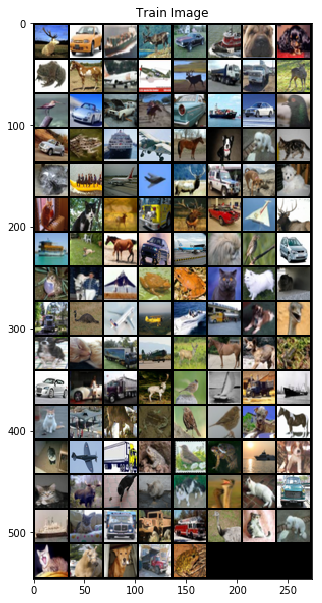

In [6]:
train_iter = iter(train_loader)
images, labels = train_iter.next()

imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

In [7]:
images.shape

torch.Size([125, 3, 32, 32])

## 13.2 Define Model

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, 5),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, 5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.fc_layer = nn.Sequential(
            nn.Linear(64 * 5 * 5, 100),
            nn.ReLU(),
            nn.Linear(100, 10)              
        )
        
    def forward(self, x):
        out = self.conv_layer(x)
        out = out.view(-1, 64*5*5)
        out = self.fc_layer(out)
        
        return out
    
model = CNN().cuda()

In [9]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

## 13.3 Train Model

In [10]:
num_epochs = 10

In [11]:
for epoch in range(num_epochs):

    total_batch = len(train_data) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = batch_images.cuda()
        Y = batch_labels.cuda()

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i+1) % 200 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))

Epoch [1/10], lter [200/400], Loss: 1.1897
Epoch [1/10], lter [400/400], Loss: 1.1029
Epoch [2/10], lter [200/400], Loss: 0.9225
Epoch [2/10], lter [400/400], Loss: 0.8486
Epoch [3/10], lter [200/400], Loss: 1.0274
Epoch [3/10], lter [400/400], Loss: 0.9080
Epoch [4/10], lter [200/400], Loss: 0.7925
Epoch [4/10], lter [400/400], Loss: 0.6647
Epoch [5/10], lter [200/400], Loss: 0.5868
Epoch [5/10], lter [400/400], Loss: 0.5252
Epoch [6/10], lter [200/400], Loss: 0.7464
Epoch [6/10], lter [400/400], Loss: 0.8418
Epoch [7/10], lter [200/400], Loss: 0.6201
Epoch [7/10], lter [400/400], Loss: 0.4909
Epoch [8/10], lter [200/400], Loss: 0.7296
Epoch [8/10], lter [400/400], Loss: 0.5093
Epoch [9/10], lter [200/400], Loss: 0.6112
Epoch [9/10], lter [400/400], Loss: 0.4492
Epoch [10/10], lter [200/400], Loss: 0.5209
Epoch [10/10], lter [400/400], Loss: 0.5013


## 13.4 Test Model

In [12]:
model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

Accuracy of test images: 75.260000 %


Predicted:    cat   car  ship plane  frog


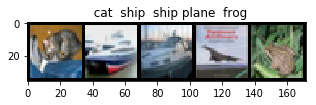

In [13]:
images, labels = iter(test_loader).next()

outputs = model(images.cuda())

_, predicted = torch.max(outputs.data, 1)
    
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(5)))

title = (' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images, normalize=True), title)